In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import jaxopt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os

import logging
logging.getLogger("jax").setLevel(logging.ERROR)
logging.getLogger("jaxopt").setLevel(logging.ERROR)

In [2]:
from lib.sim_data_i3 import I3SimHandlerFtr
from lib.plotting_tools import plot_event, adjust_plot_1d
from lib.geo import center_track_pos_and_time_based_on_data

from lib.network import get_network_eval_v_fn

from dom_track_eval import get_eval_network_doms_and_track
from time_sampler import sample_times_clean
from likelihood_fix_vertex import get_neg_mpe_llh_fix_vertex

2024-05-22 16:15:37.544814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network')
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v)

In [4]:
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandlerFtr(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [5]:
# Get a simulated muon event.

event_index = 5
meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

muon energy: 3.4 TeV
n_doms 43


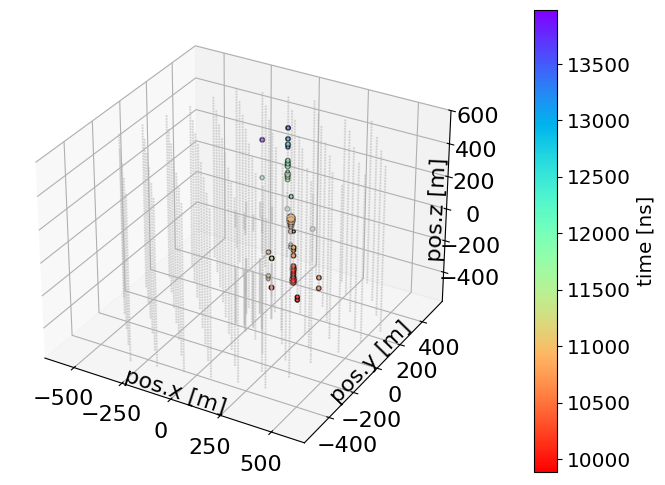

In [6]:
plot_event(event_data, geo=sim_handler.geo)

In [7]:
# Let's generate some new first hit times following our triple pandel model.
# (avoid problems with time smearing for now -> to be implemented: gaussian convoluted triple pandel.)

track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("old track vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("new track vertex:", centered_track_pos)

old track vertex: [ 143.40123598  106.94081331 -815.20509865]
new track vertex: [ -25.42355091  403.14288541 -154.63778486]


In [8]:
key = jax.random.PRNGKey(2)

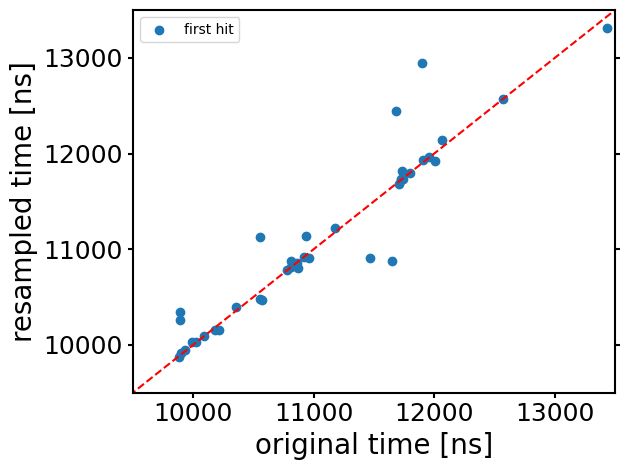

In [9]:
key, subkey = jax.random.split(key)
first_times = sample_times_clean(eval_network_doms_and_track, event_data, track_pos, track_src, track_time, subkey)

# compare to original first hit times
fig, ax = plt.subplots()
ax.scatter(event_data['time'], first_times, label='first hit')
plt.plot([0, 100000], [0, 100000], "r--")

plot_args = {'xlim':[9500, 13500],
                 'ylim':[9500, 13500],
                 'xlabel':'original time [ns]',
                 'ylabel':'resampled time [ns]'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [10]:
# Create some n_photons from qtot (by rounding up).
n_photons = np.round(event_data['charge'].to_numpy()+0.5)

# Combine into single data tensor for fitting.
fake_event_data = jnp.column_stack([jnp.array(event_data[['x', 'y', 'z']].to_numpy()), 
                                    jnp.array(first_times), 
                                    jnp.array(n_photons)])
print(fake_event_data.shape)

# Send to GPU.
fake_event_data.devices()
centered_track_pos.devices()
centered_track_time.devices()
track_src.devices()

(43, 5)


{cuda(id=0)}

In [11]:
neg_llh = get_neg_mpe_llh_fix_vertex(eval_network_doms_and_track, fake_event_data, centered_track_pos, centered_track_time)
neg_llh_v = jax.jit(jax.vmap(neg_llh, 0, 0))

In [12]:
# do a best fit from truth
solver_1 = jaxopt.ScipyMinimize(method = "bfgs", fun=neg_llh, tol = 1e-10, maxiter=2000, 
                                options = {'xrtol':1.e-10})

solver_1_sol = solver_1.run(jnp.array(track_src))
print(solver_1_sol.params)
print(np.rad2deg(solver_1_sol.params))
print(solver_1_sol.state)

[2.66320866 5.22943897]
[152.59061641 299.62478204]
ScipyMinimizeInfo(fun_val=Array(-7.06280962, dtype=float64, weak_type=True), success=True, status=0, iter_num=10, hess_inv=Array([[7.54196720e-06, 2.39048315e-05],
       [2.39048315e-05, 9.35678853e-05]], dtype=float64), num_fun_eval=Array(23, dtype=int32), num_jac_eval=Array(13, dtype=int32), num_hess_eval=Array(0, dtype=int32))


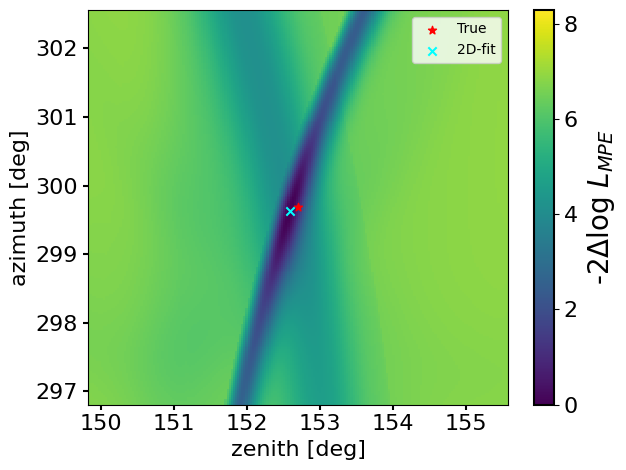

152.59977907391513
299.6672266828195
-7.059537947997927


In [13]:
n_eval = 200

zenith = np.linspace(track_src[0]-0.05, track_src[0]+0.05, n_eval)
azimuth = np.linspace(track_src[1]-0.05, track_src[1]+0.05, n_eval)
X, Y = np.meshgrid(zenith, azimuth)

init_dirs = np.column_stack([X.flatten(), Y.flatten()])
logls = neg_llh_v(init_dirs) 

logls = logls.reshape(X.shape)

fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([1.2*np.amax(delta_logl)]), shading='auto')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="True")

b_zenith = solver_1_sol.params[0]
b_azimuth = solver_1_sol.params[1]
ax.scatter(np.rad2deg([b_zenith]), np.rad2deg([b_azimuth]), marker="x", color='cyan', label='2D-fit')
plt.legend()
plt.tight_layout()
plt.show()

idx = np.argmin(logls.flatten())
print(np.rad2deg(X.flatten()[idx]))
print(np.rad2deg(Y.flatten()[idx]))
print(logls.flatten()[idx])

In [14]:
solver_2 = jaxopt.LBFGS(fun=neg_llh, 
                        maxiter=10000, 
                        max_stepsize=1.e-1, jit=True)

solver_2_sol = solver_2.run(jnp.array(track_src))
print(solver_2_sol.params)
print(np.rad2deg(solver_2_sol.params))
print(solver_2_sol.state)

[2.66320869 5.22943906]
[152.59061773 299.62478712]
LbfgsState(iter_num=Array(110, dtype=int64, weak_type=True), value=Array(-7.06280962, dtype=float64), grad=Array([0.00024986, 0.00089124], dtype=float64), stepsize=Array(0.1, dtype=float64), error=Array(0.0009256, dtype=float64), s_history=Array([[-8.50260040e-09, -2.90967836e-08],
       [-6.07398132e-09, -2.62302597e-08],
       [-6.90988244e-09, -2.31681554e-08],
       [-4.92268937e-09, -2.09296083e-08],
       [-5.52304957e-09, -1.84091355e-08],
       [-3.92304544e-09, -1.67385625e-08],
       [-4.35574021e-09, -1.46884229e-08],
       [-3.08316883e-09, -1.34179823e-08],
       [-3.42500739e-09, -1.17624133e-08],
       [-2.40640041e-09, -1.07374012e-08]], dtype=float64), y_history=Array([[-7.32427918e-04, -1.25423769e-04],
       [ 4.56441858e-04, -3.99343297e-04],
       [-6.81264613e-04, -7.47267631e-05],
       [ 3.10753610e-04, -3.04941233e-04],
       [-5.64173691e-04, -5.35198715e-05],
       [ 2.58280660e-04, -2.46378670

In [18]:
solver_2 = jaxopt.LBFGS(fun=neg_llh, jit=True, max_stepsize=0.1, linesearch="zoom")

solver_2_sol = solver_2.run(jnp.array(track_src))
print(solver_2_sol.params)
print(np.rad2deg(solver_2_sol.params))
print(solver_2_sol.state)

[2.66320869 5.22943906]
[152.59061773 299.62478712]
LbfgsState(iter_num=Array(110, dtype=int64, weak_type=True), value=Array(-7.06280962, dtype=float64), grad=Array([0.00024986, 0.00089124], dtype=float64), stepsize=Array(0.1, dtype=float64), error=Array(0.0009256, dtype=float64), s_history=Array([[-8.50260040e-09, -2.90967836e-08],
       [-6.07398132e-09, -2.62302597e-08],
       [-6.90988244e-09, -2.31681554e-08],
       [-4.92268937e-09, -2.09296083e-08],
       [-5.52304957e-09, -1.84091355e-08],
       [-3.92304544e-09, -1.67385625e-08],
       [-4.35574021e-09, -1.46884229e-08],
       [-3.08316883e-09, -1.34179823e-08],
       [-3.42500739e-09, -1.17624133e-08],
       [-2.40640041e-09, -1.07374012e-08]], dtype=float64), y_history=Array([[-7.32427918e-04, -1.25423769e-04],
       [ 4.56441858e-04, -3.99343297e-04],
       [-6.81264613e-04, -7.47267631e-05],
       [ 3.10753610e-04, -3.04941233e-04],
       [-5.64173691e-04, -5.35198715e-05],
       [ 2.58280660e-04, -2.46378670

In [42]:
def _f(zen, azi):
    return neg_llh(jnp.array([zen, azi]))

solver_1 = jaxopt.ScipyMinimize(method = "bfgs", fun=_f, tol = 1e-10, maxiter=2000, 
                                options = {'xrtol':1.e-10})

def find_min_azi(azi, zen):
    # minimize zenith
    sol = solver_1.run(zen, azi)
    # return logl
    return sol.state[0]

def _g(azi, zen):
    return neg_llh(jnp.array([zen, azi]))

solver_2 = jaxopt.ScipyMinimize(method = "bfgs", fun=_g, tol = 1e-10, maxiter=2000, 
                                options = {'xrtol':1.e-10})

def find_min_zen(zen, azi):
    # minimize zenith
    sol = solver_2.run(azi, zen)
    # return logl
    return sol.state[0]

In [43]:
print(find_min_azi(solver_1_sol.params[1], track_src[0]))

-7.062809621001001


In [44]:
print(find_min_zen(solver_1_sol.params[0], track_src[1]))

-7.062809621000934


In [28]:
%timeit find_min_azi(solver_1_sol.params[1], track_src[0])

153 ms ± 788 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
n_eval = 500
azi_vals = jnp.linspace(track_src[1]-0.05, track_src[1]+0.05, n_eval)
logl_vals = []
for azi in azi_vals:
    logl_vals.append(find_min_azi(azi, track_src[0]))

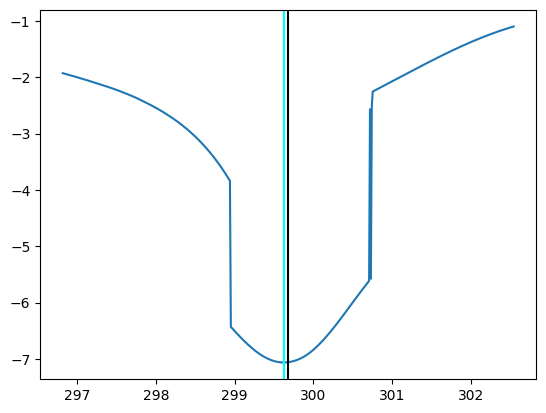

In [55]:
plt.plot(np.rad2deg(azi_vals), logl_vals)
plt.axvline(np.rad2deg([solver_1_sol.params[1]]), color='cyan')
plt.axvline(np.rad2deg([track_src[1]]), color='black')

In [52]:
n_eval = 500
zen_vals = jnp.linspace(track_src[0]-0.05, track_src[0]+0.05, n_eval)
logl_vals = []
for zen in zen_vals:
    logl_vals.append(find_min_zen(zen, track_src[1]))

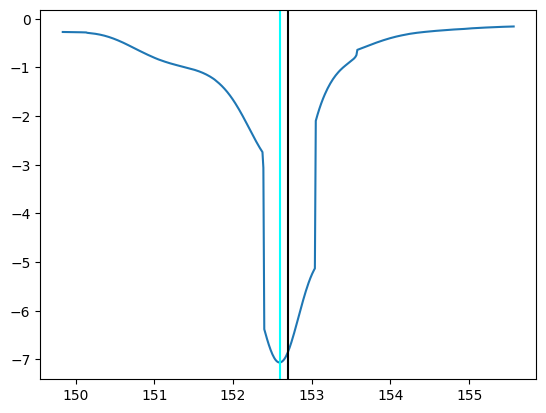

In [53]:
plt.plot(np.rad2deg(zen_vals), logl_vals)
plt.axvline(np.rad2deg([solver_1_sol.params[0]]), color='cyan')
plt.axvline(np.rad2deg([track_src[0]]), color='black')

In [28]:
find_min_azi_v = jax.vmap(find_min_azi, (0, 0), 0)
n_eval = 100
azi_vals = jnp.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
zen_vals = jnp.repeat(track_src[0], n_eval)
print(azi_vals.shape, zen_vals.shape)
logls = find_min_azi_v(azi_vals, zen_vals)

(100,) (100,)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[].
This BatchTracer with object id 140634798606192 was created on line:
  /home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jaxopt/_src/implicit_diff.py:251:11 (_custom_root.<locals>.wrapped_solver_fun)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [ ]:
"""
def f(x, args):
  a, b = args
  return jnp.sum(a + (x - b) ** 2)

def find_min(a, b):
  x0 = jnp.array([1.0])
  args = (a, b)
  return optimize.minimize(f, x0, (args,), method="BFGS")

a_grid, b_grid = jnp.meshgrid(jnp.arange(5.0), jnp.arange(5.0))

results = jax.vmap(find_min)(a_grid.ravel(), b_grid.ravel())
"""

In [74]:
from jax.scipy import optimize

@jax.jit
def minimize(x0):
    return optimize.minimize(neg_llh, x0, method="BFGS").fun

minimize_v = jax.jit(jax.vmap(minimize, 0, 0))

In [61]:
%timeit optimize.minimize(neg_llh, track_src, method="BFGS")

3.26 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
minimize(track_src)

Array(-7.06280962, dtype=float64)

In [84]:
track_src_v = jnp.repeat(track_src.reshape((1, 2)), 1000, axis=0)
minimize_v(track_src_v)

Array([-7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06280962,
       -7.06280962, -7.06280962, -7.06280962, -7.06280962, -7.06

In [88]:
%timeit minimize(track_src).block_until_ready()

81.2 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit minimize_v(track_src_v).block_until_ready()

1.65 s ± 274 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
jnp.array(5, dtype=jnp.float64)

Array(5., dtype=float64)

In [70]:
from jax.scipy import optimize

@jax.jit
def _f(zen, azi):
    return neg_llh(jnp.array([zen, azi]))

@jax.jit
def find_min_azi(azi, zen):
    # minimize zenith
    #solver_1 = jaxopt.ScipyMinimize(method = "bfgs", fun=_f, tol = 1e-10, maxiter=2000, 
    #                            options = {'xrtol':1.e-10})
    #sol = solver_1.run(zen, azi)
    # return logl
    #return sol.state[0]
    return optimize.minimize(_f, zen, (azi,), method="BFGS").fun

In [71]:
find_min_azi(jnp.array(solver_1_sol.params[1], dtype=jnp.float64), 
             jnp.array(track_src[0], dtype=jnp.float64))

IndexError: tuple index out of range

In [73]:
m = jnp.array(track_src[0])
print(m.shape[0])

IndexError: tuple index out of range

In [37]:
find_min_azi_v = jax.vmap(find_min_azi, (0, 0), 0)
n_eval = 100
azi_vals = jnp.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
zen_vals = jnp.repeat(track_src[0], n_eval)
print(azi_vals.shape, zen_vals.shape)
logls = find_min_azi_v(azi_vals, zen_vals)

(100,) (100,)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[].
This BatchTracer with object id 136396477654624 was created on line:
  /home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jaxopt/_src/implicit_diff.py:251:11 (_custom_root.<locals>.wrapped_solver_fun)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

/home/storage/hans/jax_reco/lib/plotting_tools.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


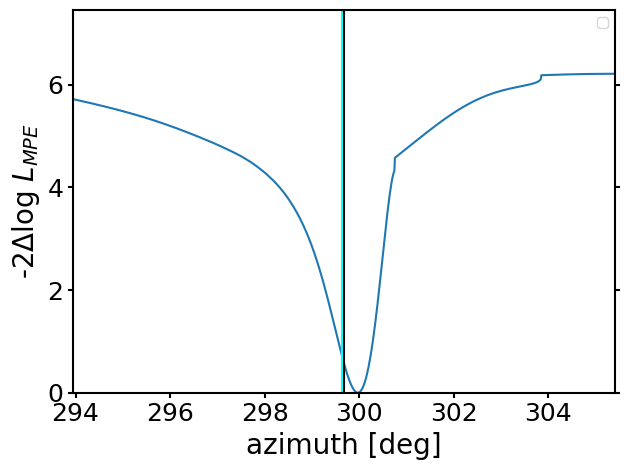

299.97412358381354
-6.833505205912859


In [34]:
n_eval = 1000
azimuth = np.linspace(track_src[1]-0.1, track_src[1]+0.1, n_eval)
zenith = np.repeat(track_src[0], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)

logls = neg_llh_v(init_dirs)

delta_logl = logls-np.amin(logls)

fig, ax = plt.subplots()
plt.plot(np.rad2deg(azimuth), delta_logl)
ax.axvline(np.rad2deg(track_src[1]), color='k')
ax.axvline(np.rad2deg([solver_1_sol.params[1]]), color='cyan')

plot_args = {'xlim':[np.rad2deg(azimuth[0]), np.rad2deg(azimuth[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'azimuth [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

print(np.rad2deg(azimuth[np.argmin(logls)]))
print(logls[np.argmin(logls)])

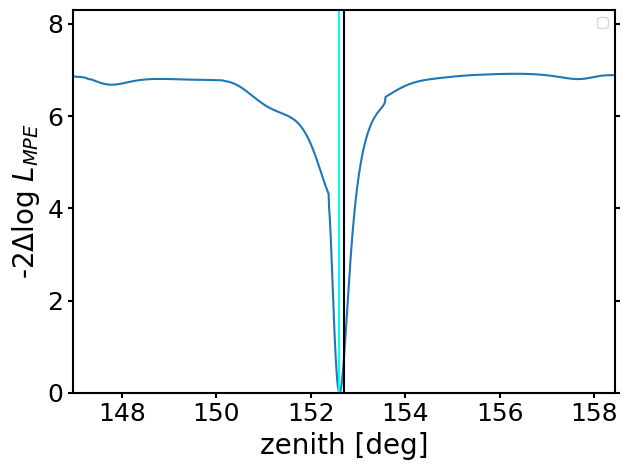

In [21]:
n_eval = 1000
zenith = np.linspace(track_src[0]-0.1, track_src[0]+0.1, n_eval)
azimuth = np.repeat(track_src[1], n_eval)
init_dirs = np.column_stack([zenith, azimuth])
init_dirs = jnp.array(init_dirs)

logls = neg_llh_v(init_dirs)

delta_logl = logls-np.amin(logls)

fig, ax = plt.subplots()
plt.plot(np.rad2deg(zenith), logls-np.amin(logls))
ax.axvline(np.rad2deg(track_src[0]), color='k')
ax.axvline(np.rad2deg([solver_1_sol.params[0]]), color='cyan')


plot_args = {'xlim':[np.rad2deg(zenith[0]), np.rad2deg(zenith[-1])],
             'ylim':[0.0, 1.2*np.amax(delta_logl)],
             'xlabel':'zenith [deg]',
             'ylabel':'-2$\\Delta$log $L_{MPE}$'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [18]:
solver_1_sol.state[0]

Array(-7.06280962, dtype=float64, weak_type=True)